In [1]:
import pandas as pd
import numpy as np
import psycopg2
import pandas.io.sql as psql
import config
import random
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from scipy.stats import chi2_contingency

In [2]:
# Call variable in config.py
dbname = config.dbname
user = 'wkp2120' # Change to your userid
password = 'HappyBirthday0108!' # Change to your password
host = config.host
port = config.port

In [3]:
connection = psycopg2.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host,
    port=port
)

In [4]:
# Set seed
random.seed(42)

In [5]:
# TRNSACT
cursor = connection.cursor()
cursor.execute('''SELECT "SKU", "STORE", "SALEDATE", "QUANTITY", "STYPE", "ORGPRICE", "SPRICE", "AMT" FROM group_3.trnsact TABLESAMPLE SYSTEM(10);''')
result = cursor.fetchall()
trnsact = pd.DataFrame(result)

column_names = [desc[0] for desc in cursor.description]
trnsact.columns = column_names
trnsact

,SKU,STORE,SALEDATE,QUANTITY,STYPE,ORGPRICE,SPRICE,AMT
0,387,2707,2004-10-14,1,P,79.0,79.0,79.0
1,387,2707,2005-07-18,1,P,79.0,79.0,79.0
2,387,2707,2005-08-07,1,P,79.0,79.0,79.0
3,387,2804,2005-07-01,1,R,79.0,79.0,79.0
4,387,2804,2005-04-10,1,P,79.0,79.0,79.0
...,...,...,...,...,...,...,...,...
11264720,9999950,7003,2004-12-19,1,P,13.5,13.5,13.5
11264721,9999950,7003,2004-11-13,1,P,13.5,13.5,13.5
11264722,9999950,7004,2005-02-20,1,P,13.5,13.5,13.5
11264723,9999950,7004,2005-02-12,1,P,13.5,13.5,13.5


In [6]:
# SKUINFO
cursor.execute('''SELECT "SKU", "DEPT", "STYLE", "COLOR", "SIZE", "BRAND" FROM group_3.skuinfo;''')
result = cursor.fetchall()
skuinfo = pd.DataFrame(result)

column_names = [desc[0] for desc in cursor.description]
skuinfo.columns = column_names
skuinfo

,SKU,DEPT,STYLE,COLOR,SIZE,BRAND
0,3,6505,00 F55KT2,WHISPERWHITE,P8EA,TURNBURY
1,4,8101,22 615CZ4,SPEARMI,S,C A SPOR
2,5,7307,7LBS 245-01,34 SILVER,KING,BEAU IDE
3,8,3404,622 F05H84,MORNING MI,2T,HARTSTRI
4,15,2301,126 MDU461,255CAMEL,12,JONES/LA
...,...,...,...,...,...,...
1556025,9999973,3103,702 S3JAYV,STONE,4,POLO JEA
1556026,9999974,9801,G50171,NAVY MULTI,10,GABAR IN
1556027,9999991,2301,026 MDU201,618RED ROSE,8,JONES/LA
1556028,9999992,1202,14 F52UN1,PALE JADE,L,CABERNET


In [7]:
# SKSTINFO
cursor.execute('''SELECT * FROM group_3.skstinfo;''')
result = cursor.fetchall()
skstinfo = pd.DataFrame(result)

column_names = [desc[0] for desc in cursor.description]
skstinfo.columns = column_names
skstinfo

,SKU,STORE,COST,RETAIL,UNCLEAR
0,3,102,123.36,440.0,0
1,3,103,123.36,440.0,0
2,3,104,123.36,440.0,0
3,3,202,123.36,440.0,0
4,3,203,123.36,440.0,0
...,...,...,...,...,...
39100546,9999997,2007,15.0,19.5,0
39100547,9999997,2707,15.0,9.75,0
39100548,9999997,3307,15.0,19.5,0
39100549,9999997,7507,15.0,19.5,0


In [8]:
cursor.close()
connection.close()

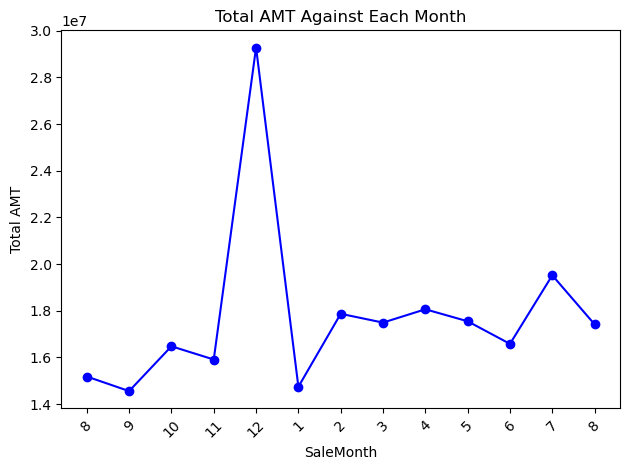

In [9]:
import datetime as dt
import matplotlib.pyplot as plt

trnsact['SALEDATE'] = pd.to_datetime(trnsact['SALEDATE'])
trnsact['SaleYear'] = trnsact['SALEDATE'].dt.year
trnsact['SaleMonth'] = trnsact['SALEDATE'].dt.month

trnsact.loc[trnsact['STYPE'] == 'R', 'AMT'] = -trnsact.loc[trnsact['STYPE'] == 'R', 'AMT']
monthly_sales = trnsact.groupby(['SaleYear', 'SaleMonth'])['AMT'].sum().reset_index()

plt.plot(monthly_sales.index, monthly_sales['AMT'], marker='o', linestyle='-', color='b')
plt.xlabel('SaleMonth')
plt.ylabel('Total AMT')
plt.title('Total AMT Against Each Month')
plt.xticks(monthly_sales.index, monthly_sales['SaleMonth'], rotation=45)
plt.tight_layout()
plt.show()

In [10]:
monthlydiscount = trnsact[trnsact['ORGPRICE'] != trnsact['SPRICE']].groupby(['SaleYear', 'SaleMonth']).SKU.count()
monthlydiscount = monthlydiscount.reset_index().rename(columns={'SKU': 'discount_item_num'})
monthlysales = trnsact.groupby(['SaleYear', 'SaleMonth']).SKU.count()
monthlysales = monthlysales.reset_index().rename(columns={'SKU': 'total_item_num'})

discount_percentage = pd.merge(monthlydiscount, monthlysales, on = ['SaleYear', 'SaleMonth'], how = 'inner')
discount_percentage['percentage'] = discount_percentage['discount_item_num'] / discount_percentage['total_item_num']
discount_percentage

,SaleYear,SaleMonth,discount_item_num,total_item_num,percentage
0,2004,8,409418,770426,0.531418
1,2004,9,500249,831667,0.601502
2,2004,10,273661,779581,0.351036
3,2004,11,262217,654689,0.400521
4,2004,12,586157,1249422,0.469143
5,2005,1,532695,825232,0.645509
6,2005,2,745633,1066147,0.699372
7,2005,3,399368,840065,0.475401
8,2005,4,272117,847167,0.321208
9,2005,5,274331,722664,0.379611


In [11]:
trnsact['AMT'] = pd.to_numeric(trnsact['AMT'], errors='coerce')
df_date = pd.pivot_table(trnsact, values = ["AMT"], index = ['SALEDATE'], aggfunc = {'AMT': 'sum'}).reset_index()
df_date

,SALEDATE,AMT
0,2004-08-01,392717.03
1,2004-08-02,352350.80
2,2004-08-03,413452.89
3,2004-08-04,425467.92
4,2004-08-05,485618.65
...,...,...
384,2005-08-23,422648.73
385,2005-08-24,740704.42
386,2005-08-25,676738.07
387,2005-08-26,799949.75


<Axes: title={'center': 'Total income amount of the transaction charge against time'}, xlabel='SALEDATE'>

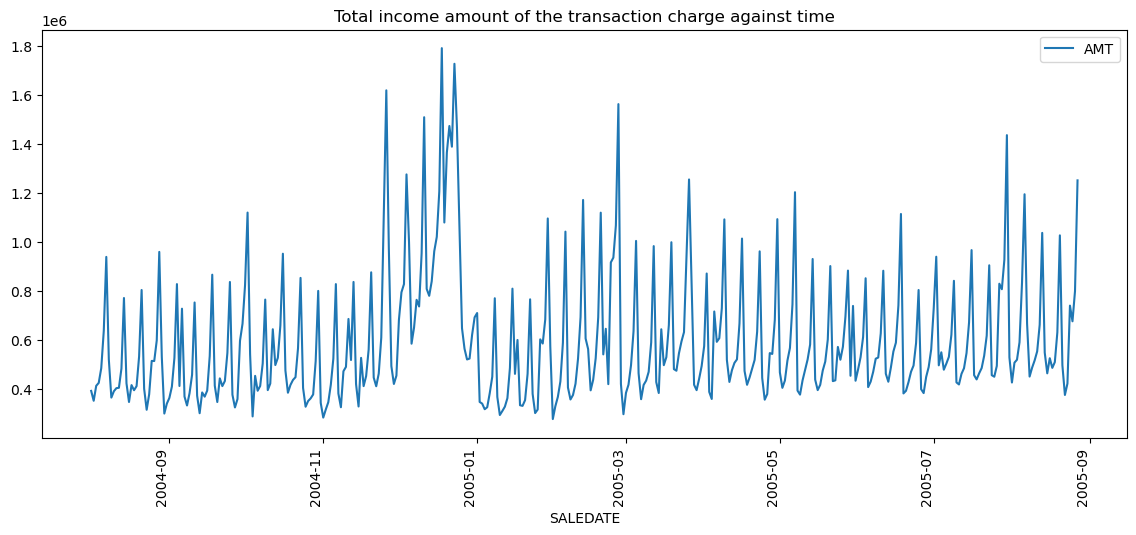

In [12]:
df_date.plot.line(x = "SALEDATE", y = "AMT", figsize = (14,6), title = "Total income amount of the transaction charge against time", rot = 90)

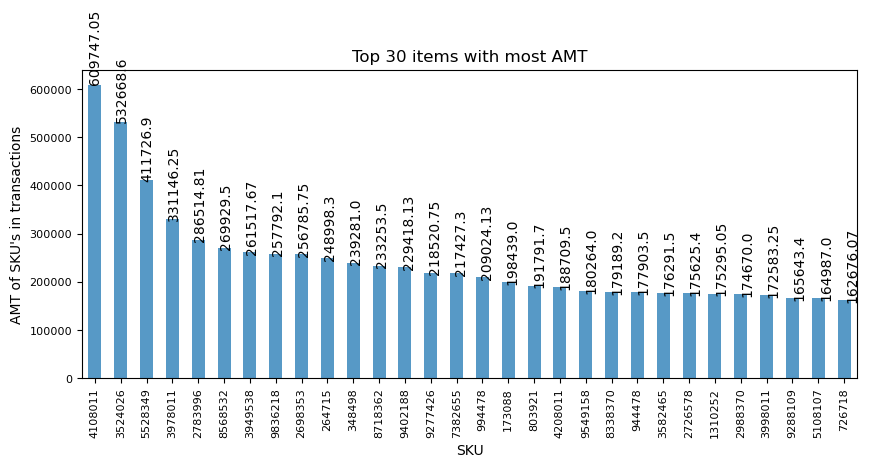

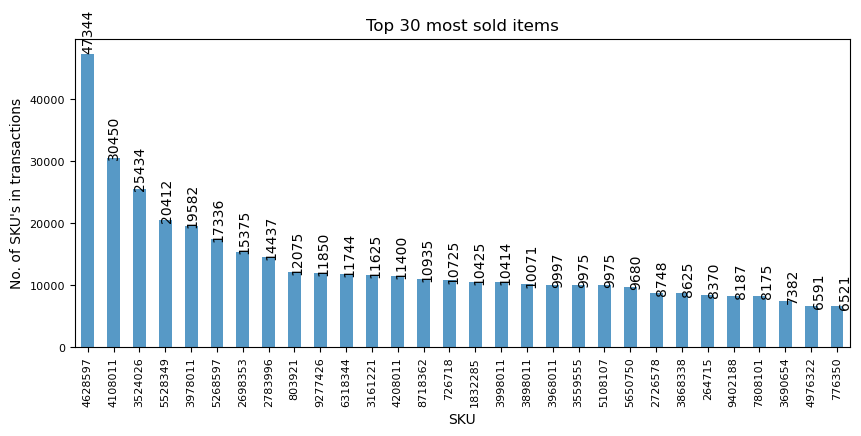

In [13]:
SKU_transactions = trnsact.groupby("SKU")['AMT'].sum().sort_values(ascending = False).head(30)

ax = SKU_transactions.plot(kind = 'bar', rot = 90, fontsize = 8, alpha = 0.75, figsize = (10,4))
plt.title("Top 30 items with most AMT")
plt.xlabel("SKU")
plt.ylabel("AMT of SKU's in transactions")

for i in ax.patches:
    ax.annotate(str(i.get_height()), 
               (i.get_x()*1.01, i.get_height()*1.01),
               rotation = 90)
plt.show()

SKU_count = trnsact.SKU.value_counts().head(30)

ax = SKU_count.plot(kind = 'bar', rot = 90, fontsize = 8, alpha = 0.75, figsize = (10,4))
plt.title("Top 30 most sold items")
plt.xlabel("SKU")
plt.ylabel("No. of SKU's in transactions")

for i in ax.patches:
    ax.annotate(str(i.get_height()), 
               (i.get_x()*1.01, i.get_height()*1.01),
               rotation = 90)
plt.show()

In [14]:
# check if retail price is equal to orgprice
merged_table = pd.merge(skstinfo, trnsact, on = ['SKU', 'STORE'], how = 'inner')
merged_table
# merged_table[merged_tabled['RETAIL'] != merged_table['ORGPRICE']]

,SKU,STORE,COST,RETAIL,UNCLEAR,SALEDATE,QUANTITY,STYPE,ORGPRICE,SPRICE,AMT,SaleYear,SaleMonth
0,387,2707,38.0,79.0,0,2004-10-14,1,P,79.0,79.0,79.0,2004,10
1,387,2707,38.0,79.0,0,2005-07-18,1,P,79.0,79.0,79.0,2005,7
2,387,2707,38.0,79.0,0,2005-08-07,1,P,79.0,79.0,79.0,2005,8
3,387,2804,38.0,79.0,0,2005-07-01,1,R,79.0,79.0,-79.0,2005,7
4,387,2804,38.0,79.0,0,2005-04-10,1,P,79.0,79.0,79.0,2005,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6308179,9999950,7003,8.4,14.0,0,2004-12-19,1,P,13.5,13.5,13.5,2004,12
6308180,9999950,7003,8.4,14.0,0,2004-11-13,1,P,13.5,13.5,13.5,2004,11
6308181,9999950,7004,8.4,14.0,0,2005-02-20,1,P,13.5,13.5,13.5,2005,2
6308182,9999950,7004,8.4,14.0,0,2005-02-12,1,P,13.5,13.5,13.5,2005,2


In [16]:
#merged_table['Revenue'] = (merged_table['SPRICE'] - merged_table['COST']) * merged_table['QUANTITY']
#merged_table.loc[merged_table['STYPE'] == 'R', 'Revenue'] = -trnsact.loc[trnsact['STYPE'] == 'R', 'Revenue']
#df_date_revenue = pd.pivot_table(merged_table, values = ["Revenue"], index = ['SALEDATE'], aggfunc = {'Revenue': 'sum'}).reset_index()
df_date_revenue

In [ ]:
df_date_revenue.plot.line(x = "SALEDATE", y = "Revenue", figsize = (14,6), title = "Total gross revenue against time", rot = 90)

## Store

In [ ]:
df_store = pd.pivot_table(trnsact,
                          values = ['SKU', "QUANTITY", "SPRICE", "AMT"],
                          index = ['STORE'], 
                          aggfunc = {'SKU':'count',
                                     'QUANTITY': 'sum',
                                     'AMT':[np.mean, 'sum']})

df_store

## ML Question: 
#### Type of Transaction Prediction: Use historical sales data to build a model to predict if the product will be returned (R) or not.

* Join STRNSACT, SKSTINFO, SKUINFO for feature selection; Further Data Cleaning

In [17]:
# Merge TRNSACT, SKSTINFO, SKUINFO
merged_df = pd.merge(trnsact, skstinfo, on=['SKU', 'STORE'], how='left')
merged_df = pd.merge(merged_df, skuinfo, on=['SKU'], how='left')

# Show column data types
merged_df.dtypes

SKU                   int64
STORE                 int64
SALEDATE     datetime64[ns]
QUANTITY              int64
STYPE                object
ORGPRICE             object
SPRICE               object
AMT                 float64
SaleYear              int32
SaleMonth             int32
COST                 object
RETAIL               object
UNCLEAR             float64
DEPT                  int64
STYLE                object
COLOR                object
SIZE                 object
BRAND                object
dtype: object

In [18]:
# Drop UNCLEAR column
merged_df = merged_df.drop('UNCLEAR', axis=1)

In [19]:
# Update data types
merged_df['SKU'] = merged_df['SKU'].astype(str)
merged_df['STORE'] = merged_df['STORE'].astype(str)
merged_df['DEPT'] = merged_df['DEPT'].astype(str)
merged_df['ORGPRICE'] = merged_df['ORGPRICE'].astype(float)
merged_df['SPRICE'] = merged_df['SPRICE'].astype(float)
merged_df['AMT'] = merged_df['AMT'].astype(float)
merged_df['COST'] = merged_df['COST'].astype(float)
merged_df['RETAIL'] = merged_df['RETAIL'].astype(float)
# Take saledate into datatime and split as specific month and year
merged_df['SALEDATE'] = pd.to_datetime(merged_df['SALEDATE'])
merged_df['year'] = merged_df['SALEDATE'].dt.year.astype('category')
merged_df['month'] = merged_df['SALEDATE'].dt.month.astype('category')
merged_df['day_of_week'] = merged_df['SALEDATE'].dt.dayofweek.astype('category')
merged_df['day_of_month'] = merged_df['SALEDATE'].dt.day.astype('category')
merged_df['quarter'] = merged_df['SALEDATE'].dt.quarter.astype('category')
# Check data types
merged_df.dtypes

SKU                     object
STORE                   object
SALEDATE        datetime64[ns]
QUANTITY                 int64
STYPE                   object
ORGPRICE               float64
SPRICE                 float64
AMT                    float64
SaleYear                 int32
SaleMonth                int32
COST                   float64
RETAIL                 float64
DEPT                    object
STYLE                   object
COLOR                   object
SIZE                    object
BRAND                   object
year                  category
month                 category
day_of_week           category
day_of_month          category
quarter               category
dtype: object

In [20]:
# Checking NA value in COST and RETAIL
merged_df[['COST', 'RETAIL']].isna().sum()

COST      4956541
RETAIL    4956541
dtype: int64

In [21]:
# Drop rows that with NA on COST and RETAIL
merged_df.dropna(subset=['COST', 'RETAIL'], inplace=True)
merged_df.head()

,SKU,STORE,SALEDATE,QUANTITY,STYPE,ORGPRICE,SPRICE,AMT,SaleYear,SaleMonth,...,DEPT,STYLE,COLOR,SIZE,BRAND,year,month,day_of_week,day_of_month,quarter
0,387,2707,2004-10-14,1,P,79.0,79.0,79.0,2004,10,...,9306,74017,BROWN,110M,TIMBERLA,2004,10,3,14,4
1,387,2707,2005-07-18,1,P,79.0,79.0,79.0,2005,7,...,9306,74017,BROWN,110M,TIMBERLA,2005,7,0,18,3
2,387,2707,2005-08-07,1,P,79.0,79.0,79.0,2005,8,...,9306,74017,BROWN,110M,TIMBERLA,2005,8,6,7,3
3,387,2804,2005-07-01,1,R,79.0,79.0,-79.0,2005,7,...,9306,74017,BROWN,110M,TIMBERLA,2005,7,4,1,3
4,387,2804,2005-04-10,1,P,79.0,79.0,79.0,2005,4,...,9306,74017,BROWN,110M,TIMBERLA,2005,4,6,10,2


In [22]:
# Featuring Engineering

# RETAIL means the price that a customer will pay when purchasing a product at a retail store
# but don't know between RETAIL AND SPRICE

# Create markup percentage columns based on SPRICE and COST
# the cost price too low means item sucks, and it might increase rate to be returned?
merged_df['Markup_Percentage'] = (merged_df['SPRICE'] - merged_df['COST']) / merged_df['COST']

# See total number of transactions per SKU, STORE
# maybe more merchandise defects exist in smaller stores?
# Since 'AMT' represents the total amount of the transaction, counting the occurrences essentially calculates the number of transactions for each 'SKU' and 'STORE' combination.
merged_df['Num_Transactions'] = merged_df.groupby(['SKU', 'STORE'])['AMT'].transform('count')

In [23]:
merged_df.dropna(subset=['Markup_Percentage'], inplace=True)

In [24]:
# total[total['Markup_Percentage']==np.inf]
finite_value = 1e10
merged_df.replace([np.inf, -np.inf], finite_value, inplace=True)

In [25]:
# The number of unique values in each column
merged_df.nunique()

SKU                  108018
STORE                   325
SALEDATE                389
QUANTITY                  1
STYPE                     2
ORGPRICE                625
SPRICE                 5011
AMT                    7808
SaleYear                  2
SaleMonth                12
COST                   3204
RETAIL                 1412
DEPT                     60
STYLE                 57589
COLOR                 17692
SIZE                   2337
BRAND                  1057
year                      2
month                    12
day_of_week               7
day_of_month             31
quarter                   4
Markup_Percentage     73600
Num_Transactions        259
dtype: int64

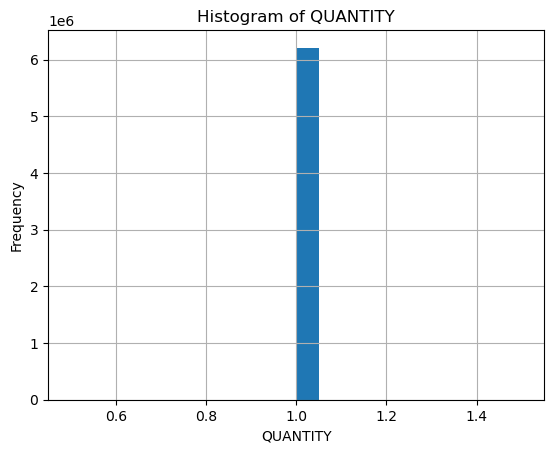

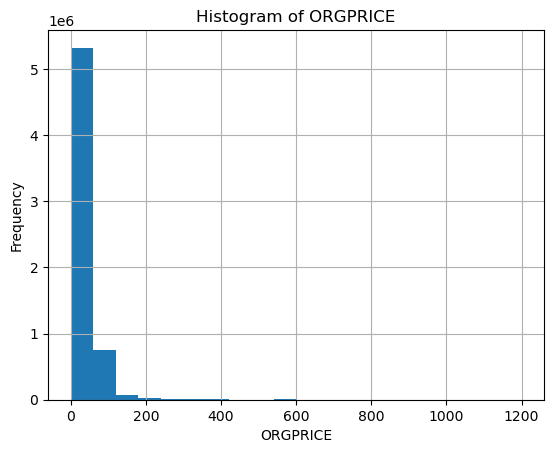

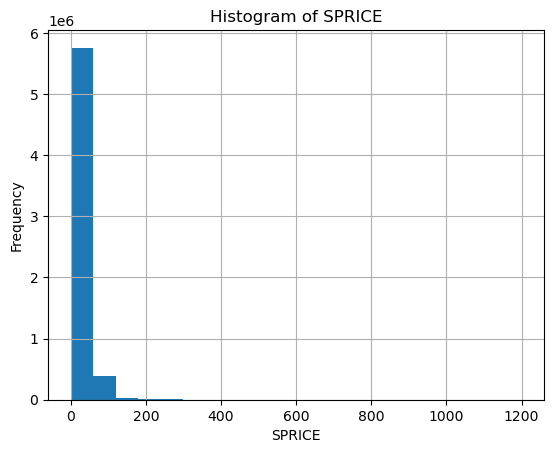

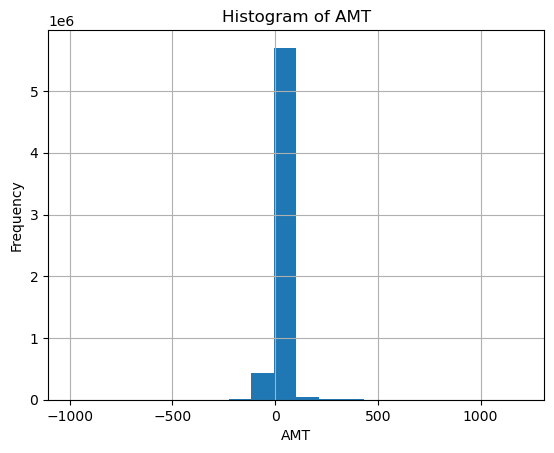

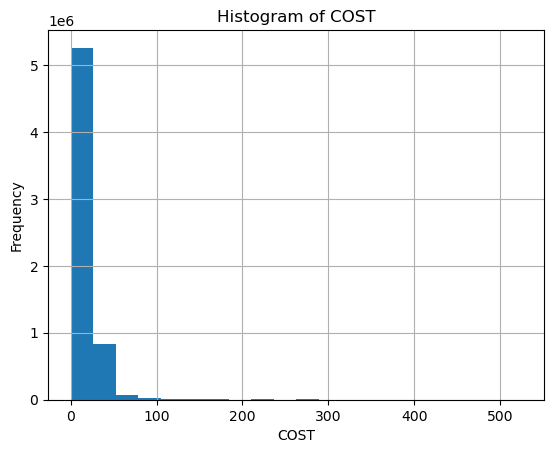

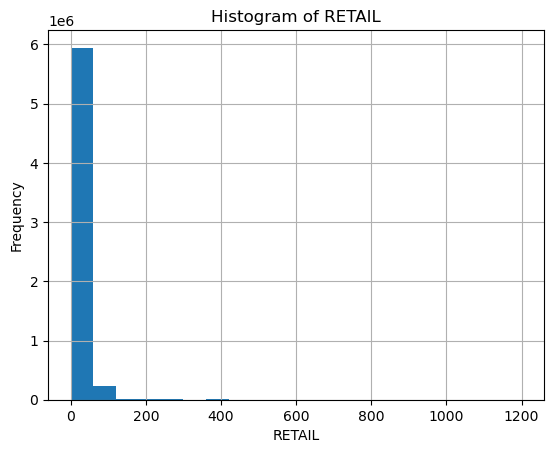

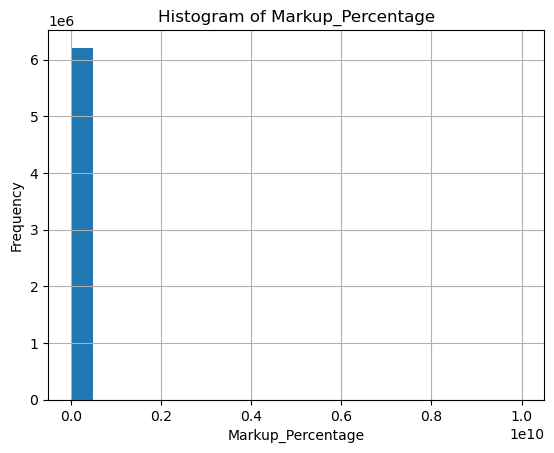

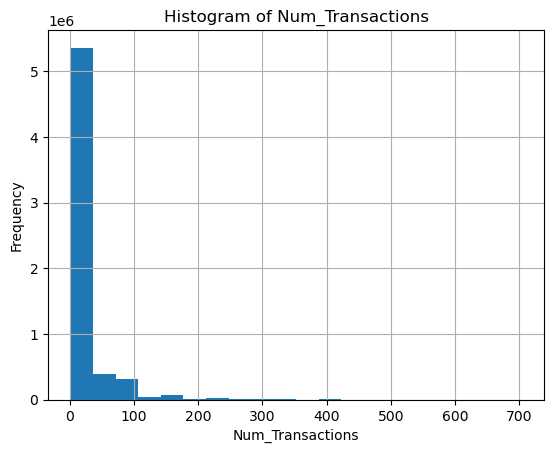

In [26]:
# Evaludate the distribution of each numerical feature
numerical_df = merged_df.select_dtypes(include=['float64', 'int64'])

# Plot a histogram for each numerical feature
for column in numerical_df.columns:
    plt.figure()  # Create a new figure for each histogram
    numerical_df[column].hist(bins=20)  # You can specify the number of bins
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
# We noticed most of them are right-skewed, we tried log transformation

/Users/yumin/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


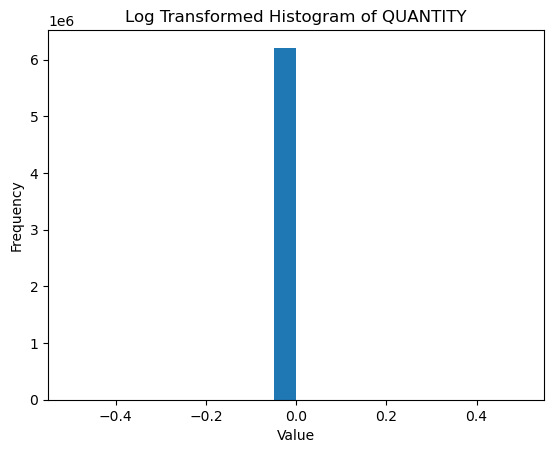

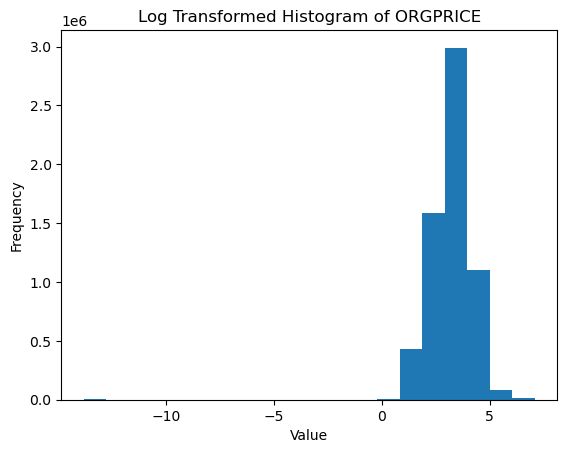

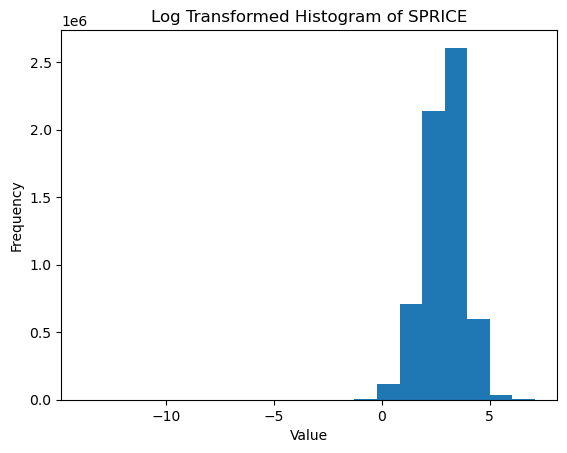

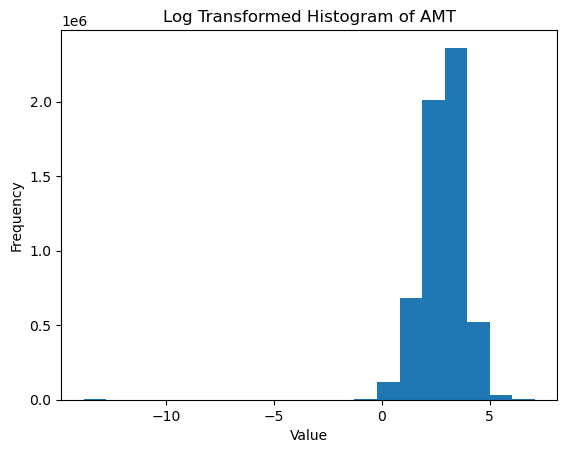

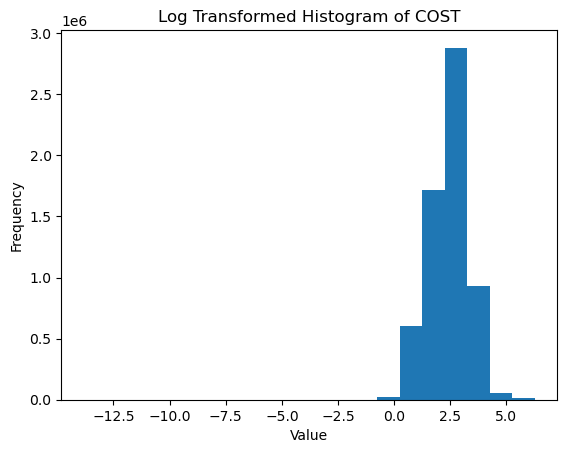

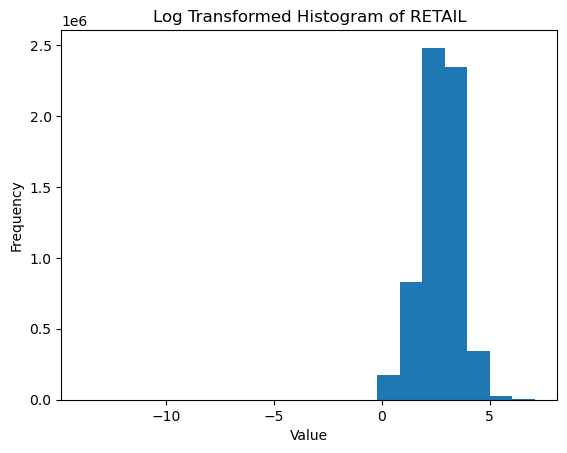

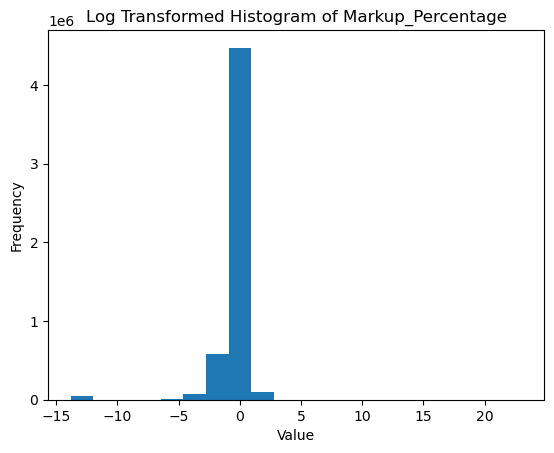

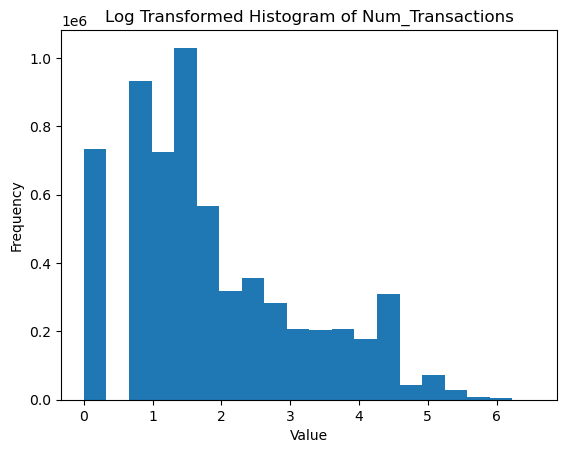

In [27]:
# Try log transformation of numerical columns
for column in numerical_df.columns:
    # Log transformation, adding a small value to avoid log(0)
    transformed = np.log(merged_df[column] + 1e-6)

    # Plotting
    plt.figure()
    plt.hist(transformed, bins=20)
    plt.title(f'Log Transformed Histogram of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.show()

In [28]:
# See how many returned items there are in each SKU.
result = merged_df.groupby(['SKU', 'STYPE']).size().unstack(fill_value=0).reset_index()
result.rename(columns={'r': 'count_r', 'p': 'count_p'}, inplace=True)
# Seems like return rate doesnt have big concern with SKU
result

STYPE,SKU,P,R
0,1000196,201,19
1,1000207,1,1
2,1000236,8,0
3,1000295,39,1
4,1000319,10,1
...,...,...,...
108013,9999819,5,0
108014,9999822,1,0
108015,9999863,8,0
108016,9999868,15,0


In [29]:
# Correlation Analysis
# Create a binary column 'Has_Discount' to indicate the presence of a discount
merged_df['Has_Discount'] = merged_df['ORGPRICE'] != merged_df['SPRICE']

# Create a contingency table
contingency_table = pd.crosstab(merged_df['STYPE'], merged_df['Has_Discount'])

chi2, p, _, _ = chi2_contingency(contingency_table)
print(chi2, p)

# Result shows us there is a significant relationship between the type of transaction ('P' or 'R') and the presence of a discount.

110.52473255800021 7.520130138855454e-26


* Log transformation

In [30]:
merged_df.columns

Index(['SKU', 'STORE', 'SALEDATE', 'QUANTITY', 'STYPE', 'ORGPRICE', 'SPRICE',
       'AMT', 'SaleYear', 'SaleMonth', 'COST', 'RETAIL', 'DEPT', 'STYLE',
       'COLOR', 'SIZE', 'BRAND', 'year', 'month', 'day_of_week',
       'day_of_month', 'quarter', 'Markup_Percentage', 'Num_Transactions',
       'Has_Discount'],
      dtype='object')

In [31]:
constant = 1e-6
merged_df['ORGPRICE'] = np.log(merged_df['ORGPRICE'] + constant)
merged_df['SPRICE'] = np.log(merged_df['SPRICE'] + constant)
merged_df['AMT'] = np.log(merged_df['AMT'] + constant)
merged_df['COST'] = np.log(merged_df['COST'] + constant)
merged_df['RETAIL'] = np.log(merged_df['RETAIL'] + constant)

/Users/yumin/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Prepare for training dataset

In [32]:
num_features = ['Markup_Percentage', 'Num_Transactions']
cat_features = ['year', 'month', 'day_of_week', 'day_of_month', 'quarter', 'Has_Discount', 'DEPT']

output = 'STYPE'

In [33]:
X = merged_df[num_features+cat_features]
y = merged_df[output]
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ]
)


In [ ]:
# Train a RandomForestClassifier model
# Set n_estimators = 10

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=10, verbose=2))])
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
# Set n_estimators = 20

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators=20, verbose=2)))])
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [36]:
# Train as Logistic Regression
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=42,max_iter=1000))])

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [37]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average="binary", pos_label='P')
recall = recall_score(y_test, y_pred, average="binary", pos_label='P')
f1score = f1_score(y_test, y_pred,average="binary", pos_label='P')

print(f"Accuracy = {accuracy}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")



# Convert 'P' to 1 and 'R' to 0 in y_test and y_pred
y_test_num = np.where(y_test == 'P', 1, 0)
y_pred_num = np.where(y_pred == 'P', 1, 0)

# Making confusion matrix

conf_matrix = (y_test_num, y_pred_num)

conf_matrix

Accuracy = 0.9226254057974398
Precision = 0.9226254057974398
Recall = 1.0
F1 Score = 0.9597557621108893


(array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]))